In [184]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import matplotlib.colors as mcolors
import re
import numpy as np
import unicodedata


/Users/rockykamenrubio/Documents/Personal-Programming/Canada_data/canada/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


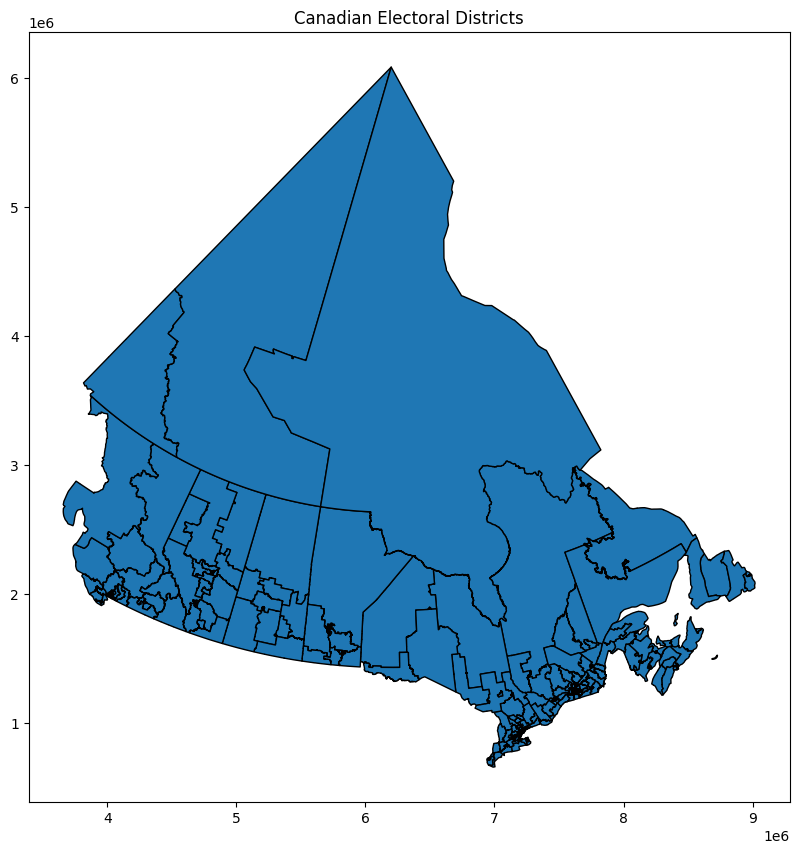

In [ ]:
# # Load the shapefile from the shapefiles folder
# shapefile_path = "shapefiles/CF_CA_2023_FR.shp"
# gdf = gpd.read_file(shapefile_path)

# # Plot the shapefile
# gdf.plot(figsize=(10, 10), edgecolor="black")
# plt.title("Canadian Electoral Districts")
# plt.show()

/Users/rockykamenrubio/Documents/Personal-Programming/Canada_data/canada/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


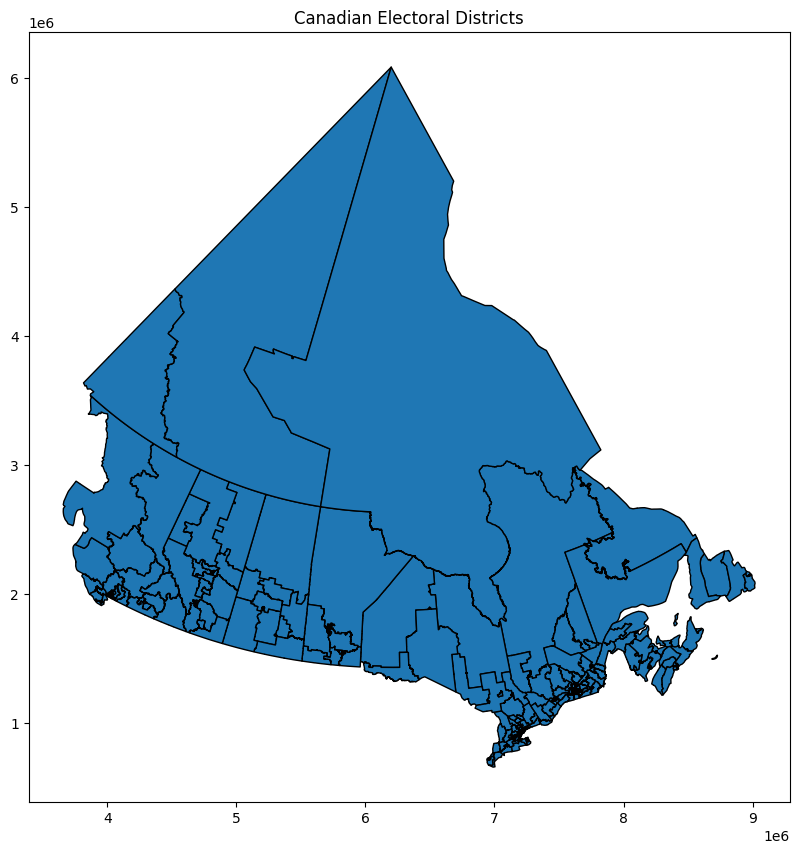

In [ ]:

# # Get all shapefiles in the "shapefiles" folder
# shapefile_paths = glob.glob("shapefiles/*.shp")

# fig, ax = plt.subplots(figsize=(10, 10))
# for shp in shapefile_paths:
#     gdf = gpd.read_file(shp)
#     gdf.plot(ax=ax, edgecolor="black")
    
# gdf = gpd.read_file(shapefile_path)

# plt.title("Canadian Electoral Districts")
# plt.show()

In [187]:

# Step 1: Fetch the webpage content
url = "https://338canada.com/districts.htm"
response = requests.get(url)
# response.raise_for_status()  # Ensure the request was successful

# Print the raw HTML
# print(response.text)


# Step 2: Parse the HTML content
soup = BeautifulSoup(response.text, "html.parser")

# Step 3: Locate the table with id="myTable"
table = soup.find("table", id="myTable")

# print(table)

# Step 4: Extract table headers with fallback if no <thead> exists
thead = table.find("thead")
if thead:
    header_row = thead
else:
    # fallback to first row of table if <thead> is missing
    header_row = table.find("tr")




In [188]:
headers = [cell.get_text(strip=True) for cell in header_row.find_all(["th", "td"])]
# print("Headers:", headers)

# Step 5: Extract table rows
rows = []
for tr in table.find("tbody").find_all("tr"):
    cells = [td.get_text(strip=True) for td in tr.find_all("td")]
    if cells:
        rows.append(cells)

# print("Rows:", rows)



# Step 6: Create a DataFrame
df = pd.DataFrame(rows)
df.columns = headers

def normalize_district_name(name):
    """
    Normalize district names to make them comparable despite encoding differences:
    1. Decode any UTF-8 encoded characters
    2. Normalize Unicode (NFKD form)
    3. Replace various dash types with standard hyphen
    4. Convert to lowercase for comparison
    5. Remove extra whitespace
    """
    if not isinstance(name, str):
        return ""
    
    # Try to fix any encoding issues
    try:
        # Handle potential double-encoded UTF-8
        name = name.encode('latin1').decode('utf-8')
    except (UnicodeDecodeError, UnicodeEncodeError):
        pass
    
    # Normalize Unicode characters
    name = unicodedata.normalize('NFKD', name)
    
    # Replace various dash types with standard hyphen
    name = name.replace('\u2014', '-')  # em dash
    name = name.replace('\u2013', '-')  # en dash
    name = name.replace('\u2019', "'")  # right single quotation mark
    name = name.replace('\u2018', "'")  # left single quotation mark
    name = re.sub(r'â\x80[\x93\x94\x99]', '-', name)  # common encoding errors for dashes
    
    # Make lowercase for easier comparison
    name = name.lower()
    
    # Remove extra whitespace
    name = ' '.join(name.split())
    
    return name

# Optional: Display the DataFrame
# print(df)

# # Optional: Save to CSV
# df.to_csv("338canada_districts.csv", index=False)


# print(df['Electoral district'])




In [189]:
# Print original entries for debugging
print("Before cleaning:")
print(df['Electoral district'].head())

# Remove leading numbers and spaces using a regex, then strip any trailing whitespace
df['Electoral district'] = df['Electoral district'].str.replace(r'^\d+\s+', '', regex=True).str.strip()

# Apply normalization to both datasets
gdf['CF_NOMAN'] = gdf['CF_NOMAN'].apply(normalize_district_name)
df['Electoral district'] = df['Electoral district'].apply(normalize_district_name)


# Print the cleaned entries
# print("\nAfter cleaning:")
# print(df['Electoral district'].head())

Before cleaning:
0                  10001 Avalon
1              10002 Cape Spear
2    10003 Central Newfoundland
3                10004 Labrador
4    10005 Long Range Mountains
Name: Electoral district, dtype: object


In [190]:
print("GeoDataFrame columns:", gdf.columns.tolist())
# gdf

GeoDataFrame columns: ['NUM_CF', 'CF_NOMFR', 'CF_NOMAN', 'DEC_REP', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry']


In [203]:

# ----- Step 1. Clean df for merging -----
# Assuming df already has an 'Electoral district' column that may start with digits.
df['Electoral district'] = df['Electoral district'].str.replace(r'^\d+\s+', '', regex=True).str.strip()
# print("Cleaned df 'Electoral district':", df['Electoral district'].head())

# ----- Step 2. Merge df with gdf -----
# gdf has the riding names in column "CF_NOMFR". 
merged = gdf.merge(df[['Electoral district', 'Latest projection']], 
                   left_on="CF_NOMAN", right_on="Electoral district", how="left")
# print("Merged columns:", merged.columns.tolist())


# Define the party colors for each rating.
# Party abbreviations: LPC, CPC, NDP, BQ, GPC.
party_colors = {
    "LPC": {
        "safe": "#d92027",    # dark red
        "likely": "#ed565c",  # light red
        "leaning": "#fa8d91"  # in-between red
    },
    "CPC": {
        "safe": "#002857",    # dark blue
        "likely": "#204f86",  # light blue
        "leaning": "#6399d9"   # in-between blue
    },
    "NDP": {
        "safe": "#f58220",    # dark green
        "likely": "#f9a054",  # light green
        "leaning": "#fabb85"   # in-between green
    },
    "BQ": {
        "safe": "#00a7ec",    # dark purple
        "likely": "#52c5f4",  # light purple
        "leaning": "#8bd8f7"   # in-between purple
    },
    "GPC": {
        "safe": "#006400",    # dark green (or you may choose a different shade for Green Party)
        "likely": "#90ee90",  # light green
        "leaning": "#a1e3a1"   # in-between green
    }
}

# Helper functions for mixing hex colors
def hex_to_rgb(hexcolor):
    hexcolor = hexcolor.lstrip("#")
    return tuple(int(hexcolor[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb):
    return "#%02x%02x%02x" % rgb

def mix_colors(hex_colors):
    rgbs = [hex_to_rgb(h) for h in hex_colors]
    avg_rgb = tuple(int(sum(channels)/len(rgbs)) for channels in zip(*rgbs))
    return rgb_to_hex(avg_rgb)

def get_projection_color(projection):
    # Handle missing values
    if not projection or (isinstance(projection, float) and np.isnan(projection)):
        return "grey"
    
    projection = projection.strip()
    
    # If the projection indicates a tossup, mix the safe colors of the parties involved.
    # Example: "Toss up LPC/CPC" or "Toss up LPC/CPC/NDP"
    if projection.startswith("Toss up"):
        parties = projection.replace("Toss up", "").strip().split("/")
        safe_colors = []
        for party in parties:
            party = party.strip().upper()
            if party in party_colors:
                safe_colors.append(party_colors[party]["safe"])
        if safe_colors:
            return mix_colors(safe_colors)
        else:
            return "grey"
    else:
        # Match projections like "LPC safe", "CPC likely", "NDP leaning", etc.
        m = re.match(r'^(LPC|CPC|NDP|BQ|GPC)\s+(safe|likely|leaning)$', projection, re.IGNORECASE)
        if m:
            party, rating = m.groups()
            party = party.upper()
            rating = rating.lower()
            if party in party_colors and rating in party_colors[party]:
                return party_colors[party][rating]
        return "grey"


# Apply the function to create a new column "mapped_color"
merged["mapped_color"] = merged["Latest projection"].apply(get_projection_color)



In [197]:
# print(merged.columns)
# print(merged['Latest projection'])
# print("Unique values:", merged['Latest projection'].unique())
# print(merged)
# print(merged['mapped_color'])

merged

NUM_CF                                          CF_NOMFR  \
0     10001                                            Avalon   
1     10002                                        Cape Spear   
2     10003                              Central Newfoundland   
3     10004                                          Labrador   
4     10005                              Long Range Mountains   
..      ...                                               ...   
338   59042                                          Victoria   
339   59043  West Vancouver—Sunshine Coast—Sea to Sky Country   
340   60001                                             Yukon   
341   61001                         Territoires du Nord-Ouest   
342   62001                                           Nunavut   

                                             CF_NOMAN DEC_REP    SHAPE_AREA  \
0                                              avalon    2023  8.020017e+09   
1                                          cape spear    2023  1.952738e+08   
2                                central newfoundland    2023  5.753553e+10   
3                                            labrador    2023  3.340563e+11   
4                                long range mountains    2023  5.788876e+10   
..                                                ...     ...           ...   
338                                          victoria    2023  4.312378e+08   
339  west vancouver-sunshine coast-sea to sky country    2023  1.512751e+10   
340                                             yukon    2023  4.566648e+11   
341                             northwest territories    2023  2.484319e+12   
342                                           nunavut    2023  4.739817e+12   

        SHAPE_LEN                                           geometry    color  \
0    4.226192e+05  POLYGON ((8927788.809 2139458.940, 8925751.137...  #1f77b4   
1    8.227809e+04  POLYGON ((8967220.454 2146355.440, 8967271.811...  #ff7f0e   
2    1.116158e+06  POLYGON ((8594916.251 2237626.529, 8594916.937...  #2ca02c   
3    5.831256e+06  POLYGON ((7621885.763 2980501.700, 7622406.154...  #d62728   
4    1.489363e+06  POLYGON ((8467419.223 2299851.634, 8468568.626...  #9467bd   
..            ...                                                ...      ...   
338  9.589455e+04  POLYGON ((3944294.546 1916926.834, 3955149.737...  #bcbd22   
339  8.746320e+05  POLYGON ((3964582.966 2047284.837, 3965059.186...  #17becf   
340  4.126711e+06  POLYGON ((3867955.960 3689808.383, 3869466.603...  #1f77b4   
341  1.017360e+07  POLYGON ((4420760.677 3406641.700, 4422984.751...  #ff7f0e   
342  1.497561e+07  POLYGON ((5060195.460 3736915.600, 5060195.571...  #2ca02c   

                                   Electoral district Latest projection  \
0                                              avalon          LPC safe   
1                                          cape spear          LPC safe   
2                                central newfoundland   Toss up LPC/CPC   
3                                            labrador        LPC likely   
4                                long range mountains        LPC likely   
..                                                ...               ...   
338                                          victoria       LPC leaning   
339  west vancouver-sunshine coast-sea to sky country          LPC safe   
340                                             yukon        LPC likely   
341                             northwest territories        LPC likely   
342                                           nunavut   Toss up LPC/NDP   

    mapped_color  
0        #e31a1c  
1        #e31a1c  
2        #712139  
3        #fc9272  
4        #fc9272  
..           ...  
338      #fcbba1  
339      #e31a1c  
340      #fc9272  
341      #fc9272  
342      #8a5e38  

[343 rows x 11 columns]

In [204]:
# Find missing entries in the merged dataframe
missing_projection = merged[merged['Latest projection'].isna()]
print(f"Found {len(missing_projection)} entries with missing Latest projection")

# Display the first few missing entries to debug the merge issue
print("\nEntries with missing Latest projection:")
print(missing_projection[['CF_NOMAN', 'Electoral district']].head(10))

# Check if any entries have missing mapped_color despite having a Latest projection
missing_color = merged[(~merged['Latest projection'].isna()) & (merged['mapped_color'].isna())]
print(f"\nFound {len(missing_color)} entries with missing mapped_color despite having Latest projection")

# Print all unique values in CF_NOMAN from gdf that don't match any Electoral district in df
print("\nChecking for potential name mismatches between datasets:")
gdf_districts = set(gdf['CF_NOMAN'])
df_districts = set(df['Electoral district'])
unmatched = gdf_districts - df_districts
print(f"Found {len(unmatched)} districts in gdf that don't match any in df")
print("Examples of unmatched districts:")
print(list(unmatched))

# Print some examples from df for comparison
print("\nExamples from df['Electoral district']:")
print(list(df_districts))

Found 1 entries with missing Latest projection

Entries with missing Latest projection:
                    CF_NOMAN Electoral district
94  rivière-des-mille-îles                NaN

Found 0 entries with missing mapped_color despite having Latest projection

Checking for potential name mismatches between datasets:
Found 1 districts in gdf that don't match any in df
Examples of unmatched districts:
['rivière-des-mille-îles']

Examples from df['Electoral district']:
['eglinton-lawrence', 'carlton trail-eagle creek', 'hamilton centre', 'st. boniface-st. vital', 'beloeil-chambly', 'davenport', 'humber river-black creek', 'labrador', 'cambridge', 'south surrey-white rock', 'kapuskasing-timmins-mushkegowuk', 'brome-missisquoi', 'mississauga-streetsville', 'wellington-halton hills north', 'york south-weston-etobicoke', 'north vancouver-capilano', 'brampton north-caledon', 'saint-laurent', 'brampton-chinguacousy park', 'middlesex-london', 'thunder bay-superior north', 'surrey newton', 'sim

In [208]:
fig, ax = plt.subplots(figsize=(200, 200))
merged.plot(ax=ax, color=merged["mapped_color"], edgecolor="black")
ax.set_title("Canadian Electoral Districts\nColored by Latest Projection")

# Create an organized legend based on party_colors mapping
legend_entries = []

# First add all the individual party projections (safe/likely/leaning)
for party, ratings in party_colors.items():
    for rating, color in ratings.items():
        legend_entries.append((f"{party} {rating}", color))

# Add the toss-up combinations found in the data
tossup_combinations = [proj for proj in merged["Latest projection"].dropna().unique() 
                       if "Toss up" in str(proj)]
for combo in tossup_combinations:
    legend_entries.append((combo, get_projection_color(combo)))

# Add grey for no data
legend_entries.append(("No data", "grey"))

# Add legend entries to the plot in a neat, organized way
for label, color in legend_entries:
    ax.scatter([], [], color=color, label=label)

ax.legend(title="Party Projections", bbox_to_anchor=(1, 1))
plt.show()

/Users/rockykamenrubio/Documents/Personal-Programming/Canada_data/canada/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


/Users/rockykamenrubio/Documents/Personal-Programming/Canada_data/canada/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


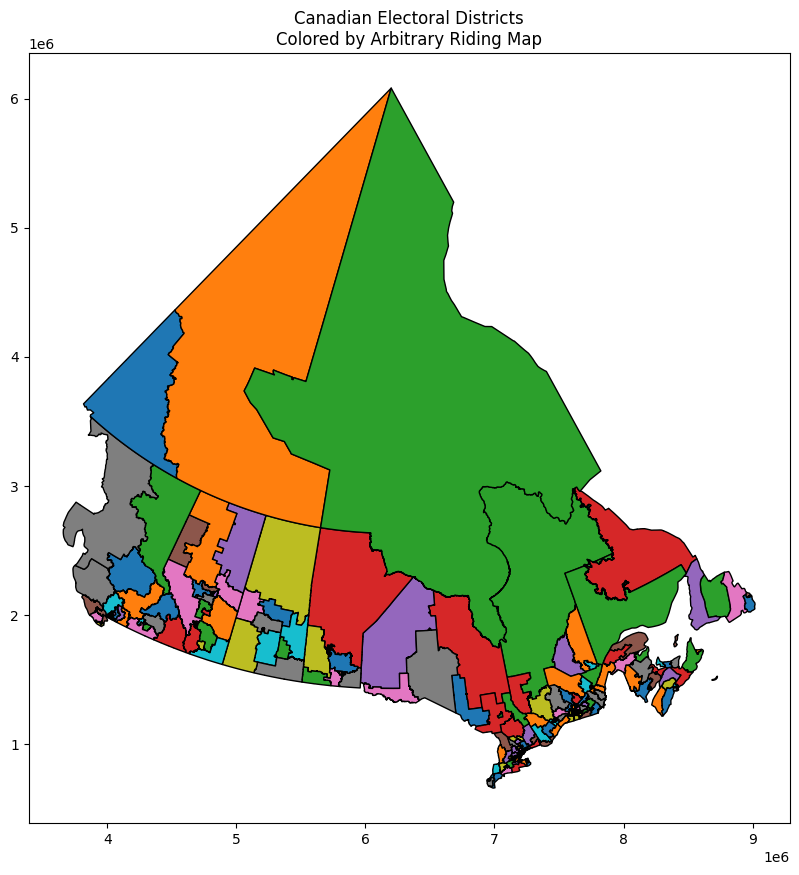

In [195]:
unique_ridings = gdf["CF_NOMFR"].unique()

# Use Tableau colors for an arbitrary mapping; cycle through colors if there are more ridings than colors available.
tableau_colors = list(mcolors.TABLEAU_COLORS.values())
color_mapping = {riding: tableau_colors[i % len(tableau_colors)] 
                 for i, riding in enumerate(unique_ridings)}

# Create a new column in the GeoDataFrame based on the mapping
gdf["color"] = gdf["CF_NOMFR"].map(color_mapping)

# Plot the GeoDataFrame using the assigned colors
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf["color"], edgecolor="black")
ax.set_title("Canadian Electoral Districts\nColored by Arbitrary Riding Map")

# Create a legend manually
for riding, color in color_mapping.items():
    ax.scatter([], [], color=color, label=riding)
# ax.legend(title="Riding", bbox_to_anchor=(1, 1))
plt.show()